In [ ]:
ENV["OMP_NUM_THREADS"] = 40

using PyCall
using XGPaint
using HDF5
using Healpix
using Unitful, UnitfulAstro
# nmt = pyimport("pymaster")

freq = 143.0
int_freq = Int(freq)

flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");
flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");

In [3]:
using XGPaint
using Healpix
# hp = pyimport("healpy")

using PyPlot
PyPlot.svg(true)
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum

# CHANGE FOR DIFFERENT FREQUENCY ==========================
# print(KCMB_to_Jy_factor(freq * 1u"GHz"))

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

tSZ_mul (generic function with 1 method)

In [4]:
nside = 4096
m_radio = HealpixMap{Float64,RingOrder}(nside)

# flux_cut = 7e-3
# cut_array = flux_143 .< flux_cut  # in Jy

XGPaint.catalog2map!(m_radio, flux, θ, ϕ)
MJy_factor = MJy_mul(freq * 1u"GHz")
m_radio .*= MJy_factor / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr

In [5]:
using PowerSpectra

# compute binning matrix
P = binning_matrix(0:50:2nside, 50:50:2nside+50, ℓ -> ℓ^2, lmax=nside2lmax(nside));
lb = P * collect(0:3nside-1)
pixelwindow = pixwin(nside)[1:nside2lmax(nside)+1];

In [6]:
using FITSIO

m_cib = readMapFromFITS("/tigress/zequnl/websky/cib_nu0$(int_freq).fits", 1, Float64);
m_cib.pixels .*= MJy_factor

tSZ_factor = tSZ_mul(freq * 1u"GHz")
m_tsz = readMapFromFITS("/tigress/zequnl/websky/tsz.fits", 1, Float64);
m_tsz .*= tSZ_factor;

In [7]:
m_kap = readMapFromFITS("/tigress/zequnl/websky/kap.fits", 1, Float64);

In [8]:
using JLD2
@load "/tigress/zequnl/radio/apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2" apo

1-element Vector{Symbol}:
 :apo

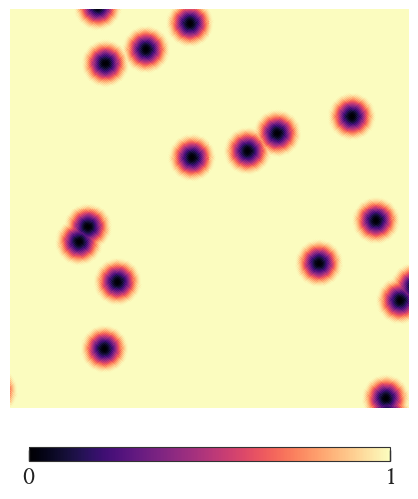

In [9]:
hp = pyimport("healpy")
plt.figure(figsize=(6,6))
hp.cartview(apo.pixels, lonra=[-2.,2.], latra=[-2.,2.], title=nothing)
# apo.pixels .= 1.0                                                          # DISABLING MASK
# plt.savefig("apodized_mask.pdf", bbox_inches="tight")

In [10]:
alm_radio = map2alm(m_radio * apo)
alm_cib = map2alm(m_cib * apo)
alm_tsz = map2alm(m_tsz * apo);
alm_kap = map2alm(m_kap * apo);

In [11]:
pcl_radio_radio = SpectralVector(alm2cl(alm_radio))
pcl_cib_cib = SpectralVector(alm2cl(alm_cib))
pcl_tsz_tsz = SpectralVector(alm2cl(alm_tsz))

pcl_radio_cib = SpectralVector(alm2cl(alm_radio, alm_cib))
pcl_cib_tsz = SpectralVector(alm2cl(alm_cib, alm_tsz))
pcl_radio_tsz = SpectralVector(alm2cl(alm_radio, alm_tsz));

In [12]:
pcl_radio_kap = SpectralVector(alm2cl(alm_radio, alm_kap))
pcl_cib_kap = SpectralVector(alm2cl(alm_cib, alm_kap))
pcl_tsz_kap = SpectralVector(alm2cl(alm_tsz, alm_kap))
pcl_kap_kap = SpectralVector(alm2cl(alm_kap, alm_kap));

In [13]:
# maskalm = map2alm(apo)
# 𝐌 = mcm(:TT, maskalm, maskalm)

In [14]:
@load joinpath(ENV["SCRATCH"], "alm.jld2") alm_radio_sehgal
@load joinpath(ENV["SCRATCH"], "maskA_mcm.jld2") 𝐌

1-element Vector{Symbol}:
 :𝐌

In [15]:
# @save joinpath(ENV["SCRATCH"], "maskA_mcm.jld2") 𝐌

In [16]:
cl_radio_radio = 𝐌 \ pcl_radio_radio

cl_radio_radio = 𝐌 \ pcl_radio_radio
cl_cib_cib = 𝐌 \ pcl_cib_cib
cl_tsz_tsz = 𝐌 \ pcl_tsz_tsz

cl_radio_cib = 𝐌 \ pcl_radio_cib
cl_cib_tsz = 𝐌 \ pcl_cib_tsz
cl_radio_tsz = 𝐌 \ pcl_radio_tsz

cl_radio_kap = 𝐌 \ pcl_radio_kap
cl_cib_kap = 𝐌 \ pcl_cib_kap
cl_tsz_kap = 𝐌 \ pcl_tsz_kap
cl_kap_kap = 𝐌 \ pcl_kap_kap;

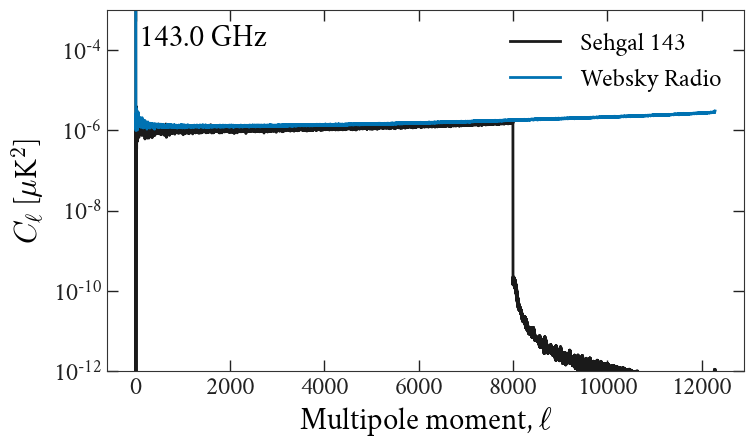

In [17]:
plt.text(0.05,0.9,"$(freq) GHz", transform=plt.gca().transAxes)

plt.plot(alm2cl(alm_radio_sehgal) ./ pixelwindow.^2, "-", label="Sehgal 143")
plt.plot(parent(cl_radio_radio)  ./ pixelwindow.^2, "-", label="Websky Radio")

plt.yscale("log")
# plt.xscale("log")
# xlim(0,2nside)
ylim(1e-12,1e-3)
# ylabel(raw"$C_{\ell}$ [$\mu$K$^2$]")


plt.xlabel(raw"Multipole moment, $\ell$")
plt.ylabel(raw"$C_{\ell}$ [$\mu$K$^2$]")
legend()
plt.tight_layout()
# plt.savefig("compare_sehgal_websky_radio_spectra_$(freq).pdf")

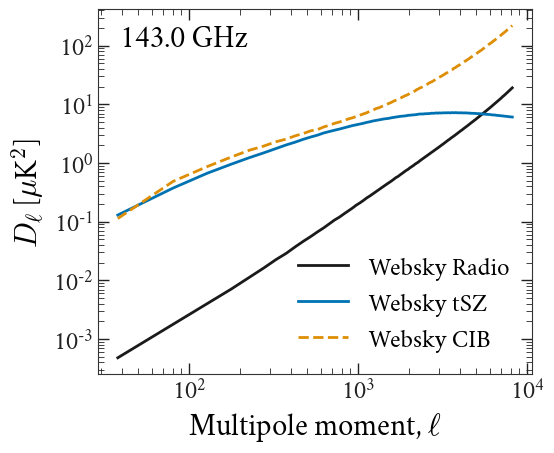

In [18]:
# plt.plot(radio_model ./ ells.^2 / 2π, "-", lw=2)

plt.figure(figsize=(6,5))
# title("$(freq) GHz")
plt.text(0.05,0.9,"$(freq) GHz", transform=plt.gca().transAxes)


Dl_factor = lb .* (lb .+ 1) ./ (2π)

plt.plot(lb, P * (parent(cl_radio_radio) ./ pixelwindow.^2) .* Dl_factor, "-", label="Websky Radio")

plt.plot(lb, P * (parent(cl_tsz_tsz) ./ pixelwindow.^2) .* Dl_factor  , "-", label="Websky tSZ")
plt.plot(lb, P * (parent(cl_cib_cib) ./ pixelwindow.^2) .* Dl_factor , "--", label="Websky CIB")
# plt.plot(lb, P * (cl_cib_cib_sehgal ./ pixwin.^2).* lb.^2, "-", label="sehgal CIB")

plt.xlabel(raw"Multipole moment, $\ell$")
plt.ylabel(raw"$D_{\ell}$ [$\mu$K$^2$]")


# plt.plot(lb, P * (cl_tsz_tsz .* 2e12), "-")
legend()
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
# ylim(1e-2, 1e3)
# savefig("spectra_$(freq).pdf")
# ylim(0,1e-4)

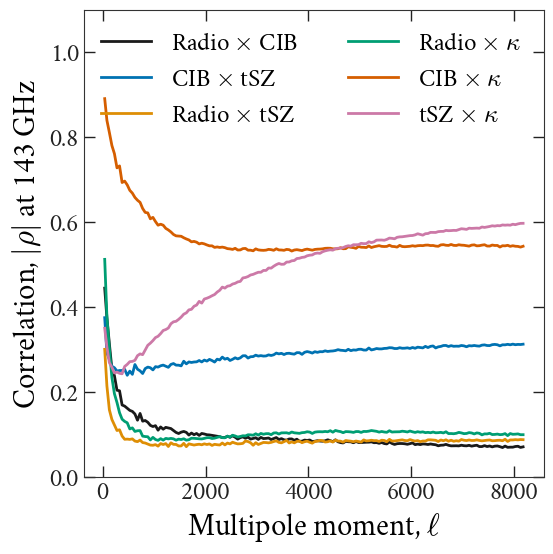

In [19]:


plt.figure(figsize=(6,6))

# plt.text(0.69,0.9,"$(freq) GHz", transform=plt.gca().transAxes)
plt.plot(lb, P * (parent(cl_radio_cib) ./ sqrt.(abs.(parent(cl_radio_radio .* cl_cib_cib))) ), 
    "-", label=raw"Radio $\times$ CIB")
plt.plot(lb, P * abs.(parent(cl_cib_tsz) ./ sqrt.(abs.(parent(cl_tsz_tsz .* cl_cib_cib))) ), 
    "-", label=raw"CIB $\times$ tSZ")
plt.plot(lb, P * abs.(parent(cl_radio_tsz) ./ sqrt.(abs.(parent(cl_radio_radio .* cl_tsz_tsz))) ), 
    "-", label=raw"Radio $\times$ tSZ")

plt.plot(lb, P * (parent(cl_radio_kap) ./ sqrt.(abs.(parent(cl_radio_radio .* cl_kap_kap))) ), 
    "-", label=raw"Radio $\times$ $\kappa$")
plt.plot(lb, P * abs.(parent(cl_cib_kap) ./ sqrt.(abs.(parent(cl_cib_cib .* cl_kap_kap))) ), 
    "-", label=raw"CIB $\times$ $\kappa$")
plt.plot(lb, P * abs.(parent(cl_tsz_kap) ./ sqrt.(abs.(parent(cl_tsz_tsz .* cl_kap_kap))) ), 
    "-", label=raw"tSZ $\times$ $\kappa$")


plt.ylabel(raw"Correlation, $|\rho|$ at 143 GHz")
plt.xlabel(raw"Multipole moment, $\ell$")
plt.ylim(0.0, 1.1)
plt.legend(ncol=2)
plt.tight_layout()
# savefig("correlations_$(freq).pdf")